In [1]:
# import the necessary packages
import torch
import os
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch.nn as nn

import pprint

In [2]:
random_seed = 1 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [3]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [15]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 32

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [16]:
subdir = ["benign_image/", "benign_mask/", "malignant_image/","malignant_mask/", "normal_image/", "normal_mask/"]
dataset = ['dataset/','train/', 'test/', 'validation/']

train_test_valid = [[[], [], []], [[], [], []], [[], [], []]]

for i in range(1, len(dataset)):
    for j in range(3):
    # for j in range(2):
        for k in range(len(os.listdir(dataset[0]+dataset[i]+subdir[j*2]))):
            train_test_valid[i-1][0].append(plt.imread(
                dataset[0]+dataset[i]+subdir[j*2]+str(k)+".jpeg"))
            train_test_valid[i-1][1].append(plt.imread(
                dataset[0]+dataset[i]+subdir[j*2+1]+str(k)+".jpeg"))
            train_test_valid[i-1][2].append(j)

X_train_npy = np.asarray(train_test_valid[0][0], dtype=np.float32)/255
y_train_npy = np.asarray(train_test_valid[0][1], dtype=np.float32)/255

X_test_npy = np.asarray(train_test_valid[1][0], dtype=np.float32)/255
y_test_npy = np.asarray(train_test_valid[1][1], dtype=np.float32)/255

X_valid_npy = np.asarray(train_test_valid[2][0], dtype=np.float32)/255
y_valid_npy = np.asarray(train_test_valid[2][1], dtype=np.float32)/255

In [17]:
def SegregateData(dataset, subdir):

    l = [
            [
                [[], [], []],
                [[], [], []],
                [[], [], []],
            ], 
            [
                [[], [], []],
                [[], [], []],
                [[], [], []],
            ],
            [
                [[], [], []],
                [[], [], []],
                [[], [], []],
            ],
        ]

    for i in range(1, 4):
        for k in range(3):
            dir_l = os.listdir(dataset[0]+dataset[i]+subdir[k*2])
            dir_l2 = os.listdir(dataset[0]+dataset[i]+subdir[k*2+1])

            l1 = []
            for j in range(len(dir_l)):
                l1.append(plt.imread(dataset[0]+dataset[i]+subdir[k*2]+dir_l[j]))
            
            l2 = []
            for j in range(len(dir_l2)):
                l2.append(plt.imread(dataset[0]+dataset[i]+subdir[k*2+1]+dir_l2[j]))

            l3=[]
            for j in range(len(dir_l2)):
                q=[0,0,0]
                q[k]=1
                l3.append(q)

            l[i-1][k][0] = np.asarray(l1, dtype=np.float32)/255
            l[i-1][k][1] = np.asarray(l2, dtype=np.float32)/255
            l[i-1][k][2] = l3

    return l

l = SegregateData(dataset, subdir)

# X_train_benign   --> l[0][0][0]  # X_test_benign   --> l[1][0][0]  # X_validation_benign   --> l[2][0][0]
# y_train_benign   --> l[0][0][1]  # y_test_benign   --> l[1][0][1]  # y_validation_benign   --> l[2][0][1]
# X_train_malgiant --> l[0][1][0]  # X_test_malgiant --> l[1][1][0]  # X_validation_malgiant --> l[2][1][0]
# y_train_malgiant --> l[0][1][1]  # y_test_malgiant --> l[1][1][1]  # y_validation_malgiant --> l[2][1][1]
# X_train_normal   --> l[0][2][0]  # X_test_normal   --> l[1][2][0]  # X_validation_normal   --> l[2][2][0]
# y_train_normal   --> l[0][2][1]  # y_test_normal   --> l[1][2][1]  # y_validation_normal   --> l[2][2][1]

In [18]:
class SegmentationDataset(Dataset):

	def __init__(self, X, y, transforms):
		self.X = X
		self.y = y
		self.transforms = transforms

	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		
		image = self.X[idx]
		mask = self.y[idx]
  
		if self.transforms is not None:
			image = self.transforms(image)
			mask = self.transforms(mask)
   
		# return a tuple of the image and its mask
		return (image, mask)

In [19]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.max = nn.MaxPool2d(2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)

    def forward(self, x):
        
        conv = self.conv_block(x)
        pool = self.max(conv)
        # drop = self.dropout(pool)
        
        # return conv, drop
        return conv, pool

In [20]:
class DecoderB1(nn.Module):
    
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = DoubleConv(mid_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)
    
    def forward(self, x, skip_features, skip_features_b2):

        x = self.conv_transpose(x)
        x = torch.cat([x, skip_features, skip_features_b2],dim=1)
        # x = self.dropout(x)
        x = self.conv_block(x)

        return x

class DecoderB2(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)
    
    def forward(self, x, skip_features):

        conv_transpose = self.conv_transpose(x)
        x = torch.cat([conv_transpose, skip_features],dim=1)
        # x = self.dropout(x)
        x = self.conv_block(x)

        return x, conv_transpose

In [21]:
class Branch1(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_block = DoubleConv(in_channels, mid_channels)
        self.conv_2d = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.conv_2d(x)
        x = self.sigmoid(x)
        
        return x

class Branch2(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_block = DoubleConv(in_channels, mid_channels)
        self.conv_2d = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.conv_2d(x)
        x = self.sigmoid(x)
        
        return x

In [22]:
class UNet(nn.Module):
    def __init__(self, input_shape=256, n_input_channels=3, n_output_channels_b1=1, n_output_channels_b2=3, n_features=64, latent_dim=128):
        super(UNet, self).__init__()
        self.input_shape = input_shape
        self.n_features = n_features
        
        self.down1 = Encoder(n_input_channels, n_features)
        self.down2 = Encoder(n_features, n_features*2)
        self.down3 = Encoder(n_features*2, n_features*4)
        self.down4 = Encoder(n_features*4, n_features*8)
        
        self.bridge = DoubleConv(n_features*8, n_features*16)
        
        self.upb1_1 = DecoderB1(n_features*16,n_features*24, n_features*8)
        self.upb1_2 = DecoderB1(n_features*8,n_features*12, n_features*4)
        self.upb1_3 = DecoderB1(n_features*4,n_features*6, n_features*2)
        self.upb1_4 = DecoderB1(n_features*2,n_features*3, n_features)
        
        flatten_size = n_features*16 * int(input_shape/16) * int(input_shape/16)
        
        self.intermediate1 = nn.Sequential(
            nn.Linear(flatten_size, latent_dim*2),
            nn.BatchNorm1d(latent_dim*2),
            nn.ReLU(inplace=True),
        )
        
        self.fc_mu = nn.Linear(latent_dim*2, latent_dim)
        self.fc_var = nn.Linear(latent_dim*2, latent_dim)
        
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, flatten_size),
            nn.ReLU(inplace=True),
        )
        
        self.upb2_1 = DecoderB2(n_features*16, n_features*8)
        self.upb2_2 = DecoderB2(n_features*8, n_features*4)
        self.upb2_3 = DecoderB2(n_features*4, n_features*2)
        self.upb2_4 = DecoderB2(n_features*2, n_features)
        
        self.outchannel_b1_grayscale = Branch1(n_features, n_features, n_output_channels_b1)
        self.outchannel_b1_rgb = Branch2(n_features, n_features, n_output_channels_b2)
        self.outchannel_b2_grayscale = Branch2(n_features, n_features, n_output_channels_b2)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return eps * std + mu
    
    def forward(self, x):
        
        conv1, pool1 = self.down1(x)
        conv2, pool2 = self.down2(pool1)
        conv3, pool3 = self.down3(pool2)
        conv4, pool4 = self.down4(pool3)
        
        bridge = self.bridge(pool4)
        
        #2nd branch vae
        
        flattened_bridge = torch.flatten(bridge, start_dim=1)
        intermediate1 = self.intermediate1(flattened_bridge)
        
        mu = self.fc_mu(intermediate1)
        log_var = self.fc_var(intermediate1)
        
        z = self.reparameterize(mu,log_var)
        
        result = self.decoder_input(z)
        reshaped_result = result.view(-1, self.n_features*16, int(self.input_shape/16),int(self.input_shape/16))
        
        # 2nd branch
        decoder_b2_1,decoder_b2_conv_transpose_1 = self.upb2_1(reshaped_result, conv4)
        decoder_b2_2,decoder_b2_conv_transpose_2 = self.upb2_2(decoder_b2_1, conv3)
        decoder_b2_3,decoder_b2_conv_transpose_3 = self.upb2_3(decoder_b2_2, conv2)
        decoder_b2_4,decoder_b2_conv_transpose_4 = self.upb2_4(decoder_b2_3, conv1)
                
        b2_rgb = self.outchannel_b2_grayscale(decoder_b2_4)
        
        # 1st branch
        decoder_b1_1 = self.upb1_1(bridge, decoder_b2_conv_transpose_1, conv4)
        decoder_b1_2 = self.upb1_2(decoder_b1_1, decoder_b2_conv_transpose_2, conv3)
        decoder_b1_3 = self.upb1_3(decoder_b1_2, decoder_b2_conv_transpose_3, conv2)
        decoder_b1_4 = self.upb1_4(decoder_b1_3, decoder_b2_conv_transpose_4, conv1)
                
        b1_gry = self.outchannel_b1_grayscale(decoder_b1_4)
        b1_rgb = self.outchannel_b1_rgb(decoder_b1_4)
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        
        return b1_gry, b1_rgb, b2_rgb, kld_loss

In [23]:
#custom dice loss
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [24]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print("Best validation dice loss: {:.4f}".format(self.best_valid_loss)+f" , Saving best model for epoch: {epoch+1}.")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, MODEL_PATH)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer, checkpoint['epoch']

In [25]:
# define transformations
transforms_ = transforms.Compose([transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(X=X_train_npy, y=y_train_npy, transforms=transforms_)
validDS = SegmentationDataset(X=X_valid_npy, y=y_valid_npy, transforms=transforms_)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(validDS)} examples in the validation set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True,drop_last=True)
# validLoader = DataLoader(validDS, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True,drop_last=True)
validLoader = DataLoader(validDS, batch_size=1, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True)

# initialize our UNet model
n_features = 64
input_shape= 256

unet = UNet(input_shape=input_shape, n_input_channels=3, n_output_channels_b1=1,
            n_output_channels_b2=3, n_features= n_features, latent_dim=128).to(DEVICE)

save_best_model = SaveBestModel()

# initialize loss function and optimizer
optimizer = Adam(unet.parameters(), lr=INIT_LR, weight_decay=1e-5)

dice = DiceLoss()
mse = nn.MSELoss()

# calculate steps per epoch for training and valid set
trainSteps = len(trainDS) // BATCH_SIZE
# validSteps = len(validDS) // BATCH_SIZE
validSteps = len(validDS) // 1

[INFO] found 897 examples in the training set...
[INFO] found 303 examples in the validation set...


In [26]:
# initialize a dictionary to store training history
train_history = {
    "train_loss": [],
	"train_dice_loss": [],
	"train_mse_b1_ip": [],
	"train_mse_b2_ip": [],
	"train_mse_b1_b2": [],
	"train_kld_loss_": [],
}

valid_history = {
	"valid_loss": [],
    "valid_dice_loss": [],
	"valid_mse_b1_ip": [],
	"valid_mse_b2_ip": [],
	"valid_mse_b1_b2": [],
	"valid_kld_loss_": [],
}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

for e in tqdm(range(NUM_EPOCHS)):

	print("-"*150)

	# set the model in training mode
	unet.train()
 
	# initialize the total training and validation loss
	total_train_loss = 0

	total_train_dice_loss = 0
	total_train_mse_b1_ip = 0
	total_train_mse_b2_ip = 0
	total_train_mse_b1_b2 = 0
	total_train_kld_loss_ = 0
 
	total_valid_loss = 0
 
	total_valid_dice_loss = 0
	total_valid_mse_b1_ip = 0
	total_valid_mse_b2_ip = 0
	total_valid_mse_b1_b2 = 0
	total_valid_kld_loss_ = 0

	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# print(i)
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
  
		# perform a forward pass and calculate the training loss
  
		pred_b1_gry, pred_b1_rgb, pred_b2_rgb, kld_loss = unet(x)

		dice_loss = dice(pred_b1_gry, y)
		mse_b1_ip = mse(pred_b1_rgb.view(-1), x.view(-1))
		mse_b2_ip = mse(pred_b2_rgb.view(-1), x.view(-1))
		mse_b1_b2 = mse(pred_b1_rgb.view(-1), pred_b2_rgb.view(-1))

		loss = dice_loss + mse_b1_ip + mse_b2_ip + mse_b1_b2 + kld_loss

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# add the loss to the total training loss so far
  
		total_train_dice_loss += dice_loss
		total_train_mse_b1_ip += mse_b1_ip
		total_train_mse_b2_ip += mse_b2_ip
		total_train_mse_b1_b2 += mse_b1_b2
		total_train_kld_loss_ += kld_loss
  
		total_train_loss += loss
	
 
	# switch off autograd
	with torch.no_grad():
    
		# set the model in evaluation mode
		unet.eval()
  
		# loop over the validation set
		for (x_v, y_v) in validLoader:
      
			# send the input to the device
			(x_v, y_v) = (x_v.to(DEVICE), y_v.to(DEVICE))


			# make the predictions and calculate the validation loss
			valid_pred_b1_gry, valid_pred_b1_rgb, valid_pred_b2_rgb, valid_kld_loss = unet(x_v)

			valid_dice_loss = dice(valid_pred_b1_gry, y_v)
			valid_mse_b1_ip = mse(valid_pred_b1_rgb.view(-1), x_v.view(-1))
			valid_mse_b2_ip = mse(valid_pred_b2_rgb.view(-1), x_v.view(-1))
			valid_mse_b1_b2 = mse(valid_pred_b1_rgb.view(-1), valid_pred_b2_rgb.view(-1))

			valid_loss = valid_dice_loss + valid_mse_b1_ip + valid_mse_b2_ip + valid_mse_b1_b2 + valid_kld_loss
   
			# add the loss to the total validation loss so far
			total_valid_dice_loss += valid_dice_loss
			total_valid_mse_b1_ip += valid_mse_b1_ip
			total_valid_mse_b2_ip += valid_mse_b2_ip
			total_valid_mse_b1_b2 += valid_mse_b1_b2
			total_valid_kld_loss_ += valid_kld_loss
   
			total_valid_loss += valid_loss
   
	# calculate the average training loss
	avg_train_loss = total_train_loss / trainSteps
 
	avg_train_dice_loss = total_train_dice_loss / trainSteps
	avg_train_mse_b1_ip = total_train_mse_b1_ip / trainSteps
	avg_train_mse_b2_ip = total_train_mse_b2_ip / trainSteps
	avg_train_mse_b1_b2 = total_train_mse_b1_b2 / trainSteps
	avg_train_kld_loss_ = total_train_kld_loss_ / trainSteps
   
	# calculate the average validation loss
	avg_valid_loss = total_valid_loss / validSteps
 
	avg_valid_dice_loss = total_valid_dice_loss / validSteps
	avg_valid_mse_b1_ip = total_valid_mse_b1_ip / validSteps
	avg_valid_mse_b2_ip = total_valid_mse_b2_ip / validSteps
	avg_valid_mse_b1_b2 = total_valid_mse_b1_b2 / validSteps
	avg_valid_kld_loss_ = total_valid_kld_loss_ / validSteps
 
	# update our training history

	train_history["train_loss"].append(avg_train_loss.cpu().detach().numpy())
 
	train_history["train_dice_loss"].append(avg_train_dice_loss.cpu().detach().numpy())
	train_history["train_mse_b1_ip"].append(avg_train_mse_b1_ip.cpu().detach().numpy())
	train_history["train_mse_b2_ip"].append(avg_train_mse_b2_ip.cpu().detach().numpy())
	train_history["train_mse_b1_b2"].append(avg_train_mse_b1_b2.cpu().detach().numpy())
	train_history["train_kld_loss_"].append(avg_train_kld_loss_.cpu().detach().numpy())
 
	valid_history["valid_loss"].append(avg_valid_loss.cpu().detach().numpy())
 
	valid_history["valid_dice_loss"].append(avg_valid_dice_loss.cpu().detach().numpy())
	valid_history["valid_mse_b1_ip"].append(avg_valid_mse_b1_ip.cpu().detach().numpy())
	valid_history["valid_mse_b2_ip"].append(avg_valid_mse_b2_ip.cpu().detach().numpy())
	valid_history["valid_mse_b1_b2"].append(avg_valid_mse_b1_b2.cpu().detach().numpy())
	valid_history["valid_kld_loss_"].append(avg_valid_kld_loss_.cpu().detach().numpy())
 
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))

	print("Train Loss : {:.4f}, Train Dice Loss : {:.4f}, Train MSE B1 ip : {:.4f}, Train MSE B2 ip : {:.4f}, Train MSE B1 B2 : {:.4f}, Train KLD Loss  : {:.4f}"
    .format(avg_train_loss, avg_train_dice_loss, avg_train_mse_b1_ip, avg_train_mse_b2_ip, avg_train_mse_b1_b2, avg_train_kld_loss_))
 
	print("Valid Loss : {:.4f}, Valid Dice Loss : {:.4f}, Valid MSE B1 ip : {:.4f}, Valid MSE B2 ip : {:.4f}, Valid MSE B1 B2 : {:.4f}, Valid KLD Loss  : {:.4f}"
    .format(avg_valid_loss, avg_valid_dice_loss, avg_valid_mse_b1_ip, avg_valid_mse_b2_ip, avg_valid_mse_b1_b2, avg_valid_kld_loss_))

	save_best_model(avg_valid_dice_loss, e, unet, optimizer)
	
# display the total time needed to perform the training
endTime = time.time()
print("-"*150)
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 1/20
Train Loss : 3.4224, Train Dice Loss : 0.8449, Train MSE B1 ip : 0.0225, Train MSE B2 ip : 0.0159, Train MSE B1 B2 : 0.0027, Train KLD Loss  : 2.5365
Valid Loss : 1.0622, Valid Dice Loss : 0.8720, Valid MSE B1 ip : 0.0606, Valid MSE B2 ip : 0.0187, Valid MSE B1 B2 : 0.0342, Valid KLD Loss  : 0.0767
Best validation dice loss: 0.8720 , Saving best model for epoch: 1.


  5%|▌         | 1/20 [01:13<23:07, 73.01s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 2/20
Train Loss : 1.0865, Train Dice Loss : 0.7681, Train MSE B1 ip : 0.0053, Train MSE B2 ip : 0.0030, Train MSE B1 B2 : 0.0012, Train KLD Loss  : 0.3089
Valid Loss : 0.8669, Valid Dice Loss : 0.8313, Valid MSE B1 ip : 0.0032, Valid MSE B2 ip : 0.0018, Valid MSE B1 B2 : 0.0015, Valid KLD Loss  : 0.0292
Best validation dice loss: 0.8313 , Saving best model for epoch: 2.


 10%|█         | 2/20 [02:26<21:57, 73.18s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 3/20
Train Loss : 0.8641, Train Dice Loss : 0.7230, Train MSE B1 ip : 0.0022, Train MSE B2 ip : 0.0015, Train MSE B1 B2 : 0.0006, Train KLD Loss  : 0.1369
Valid Loss : 0.8297, Valid Dice Loss : 0.7860, Valid MSE B1 ip : 0.0019, Valid MSE B2 ip : 0.0009, Valid MSE B1 B2 : 0.0009, Valid KLD Loss  : 0.0399
Best validation dice loss: 0.7860 , Saving best model for epoch: 3.


 15%|█▌        | 3/20 [03:39<20:45, 73.24s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 4/20
Train Loss : 0.7344, Train Dice Loss : 0.6722, Train MSE B1 ip : 0.0019, Train MSE B2 ip : 0.0011, Train MSE B1 B2 : 0.0007, Train KLD Loss  : 0.0585
Valid Loss : 0.8315, Valid Dice Loss : 0.7827, Valid MSE B1 ip : 0.0032, Valid MSE B2 ip : 0.0009, Valid MSE B1 B2 : 0.0022, Valid KLD Loss  : 0.0426
Best validation dice loss: 0.7827 , Saving best model for epoch: 4.


 20%|██        | 4/20 [04:52<19:31, 73.23s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 25%|██▌       | 5/20 [06:01<17:51, 71.43s/it]

[INFO] EPOCH: 5/20
Train Loss : 0.6792, Train Dice Loss : 0.6370, Train MSE B1 ip : 0.0013, Train MSE B2 ip : 0.0009, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0396
Valid Loss : 0.8478, Valid Dice Loss : 0.8102, Valid MSE B1 ip : 0.0010, Valid MSE B2 ip : 0.0006, Valid MSE B1 B2 : 0.0003, Valid KLD Loss  : 0.0356
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 6/20
Train Loss : 0.6224, Train Dice Loss : 0.5857, Train MSE B1 ip : 0.0011, Train MSE B2 ip : 0.0006, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0347
Valid Loss : 0.7506, Valid Dice Loss : 0.7275, Valid MSE B1 ip : 0.0012, Valid MSE B2 ip : 0.0005, Valid MSE B1 B2 : 0.0008, Valid KLD Loss  : 0.0206
Best validation dice loss: 0.7275 , Saving best model for epoch: 6.


 30%|███       | 6/20 [07:14<16:49, 72.14s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 7/20
Train Loss : 0.5571, Train Dice Loss : 0.5303, Train MSE B1 ip : 0.0013, Train MSE B2 ip : 0.0008, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0243
Valid Loss : 0.7504, Valid Dice Loss : 0.7234, Valid MSE B1 ip : 0.0019, Valid MSE B2 ip : 0.0006, Valid MSE B1 B2 : 0.0012, Valid KLD Loss  : 0.0233
Best validation dice loss: 0.7234 , Saving best model for epoch: 7.


 35%|███▌      | 7/20 [08:27<15:42, 72.49s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 8/20
Train Loss : 0.5472, Train Dice Loss : 0.5127, Train MSE B1 ip : 0.0011, Train MSE B2 ip : 0.0006, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0324
Valid Loss : 0.7391, Valid Dice Loss : 0.6998, Valid MSE B1 ip : 0.0025, Valid MSE B2 ip : 0.0007, Valid MSE B1 B2 : 0.0022, Valid KLD Loss  : 0.0339
Best validation dice loss: 0.6998 , Saving best model for epoch: 8.


 40%|████      | 8/20 [09:40<14:31, 72.66s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 45%|████▌     | 9/20 [10:48<13:03, 71.20s/it]

[INFO] EPOCH: 9/20
Train Loss : 0.5499, Train Dice Loss : 0.5201, Train MSE B1 ip : 0.0013, Train MSE B2 ip : 0.0008, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0273
Valid Loss : 0.7721, Valid Dice Loss : 0.7400, Valid MSE B1 ip : 0.0064, Valid MSE B2 ip : 0.0006, Valid MSE B1 B2 : 0.0055, Valid KLD Loss  : 0.0197
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 10/20
Train Loss : 0.5662, Train Dice Loss : 0.5354, Train MSE B1 ip : 0.0013, Train MSE B2 ip : 0.0006, Train MSE B1 B2 : 0.0006, Train KLD Loss  : 0.0284
Valid Loss : 0.7116, Valid Dice Loss : 0.6923, Valid MSE B1 ip : 0.0013, Valid MSE B2 ip : 0.0006, Valid MSE B1 B2 : 0.0008, Valid KLD Loss  : 0.0166
Best validation dice loss: 0.6923 , Saving best model for epoch: 10.


 50%|█████     | 10/20 [12:02<11:58, 71.89s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 55%|█████▌    | 11/20 [13:10<10:36, 70.74s/it]

[INFO] EPOCH: 11/20
Train Loss : 0.5304, Train Dice Loss : 0.5132, Train MSE B1 ip : 0.0012, Train MSE B2 ip : 0.0006, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0148
Valid Loss : 0.7095, Valid Dice Loss : 0.6955, Valid MSE B1 ip : 0.0015, Valid MSE B2 ip : 0.0006, Valid MSE B1 B2 : 0.0006, Valid KLD Loss  : 0.0114
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 12/20
Train Loss : 0.5082, Train Dice Loss : 0.4954, Train MSE B1 ip : 0.0010, Train MSE B2 ip : 0.0007, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0106
Valid Loss : 0.6741, Valid Dice Loss : 0.6666, Valid MSE B1 ip : 0.0007, Valid MSE B2 ip : 0.0005, Valid MSE B1 B2 : 0.0005, Valid KLD Loss  : 0.0059
Best validation dice loss: 0.6666 , Saving best model for epoch: 12.


 60%|██████    | 12/20 [14:23<09:32, 71.56s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 65%|██████▌   | 13/20 [15:31<08:13, 70.53s/it]

[INFO] EPOCH: 13/20
Train Loss : 0.5033, Train Dice Loss : 0.4876, Train MSE B1 ip : 0.0009, Train MSE B2 ip : 0.0005, Train MSE B1 B2 : 0.0004, Train KLD Loss  : 0.0139
Valid Loss : 0.7975, Valid Dice Loss : 0.7388, Valid MSE B1 ip : 0.0014, Valid MSE B2 ip : 0.0004, Valid MSE B1 B2 : 0.0008, Valid KLD Loss  : 0.0560
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 14/20
Train Loss : 0.4759, Train Dice Loss : 0.4590, Train MSE B1 ip : 0.0011, Train MSE B2 ip : 0.0007, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0148
Valid Loss : 0.6639, Valid Dice Loss : 0.6483, Valid MSE B1 ip : 0.0006, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0144
Best validation dice loss: 0.6483 , Saving best model for epoch: 14.


 70%|███████   | 14/20 [16:45<07:08, 71.40s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 75%|███████▌  | 15/20 [17:53<05:51, 70.36s/it]

[INFO] EPOCH: 15/20
Train Loss : 0.4499, Train Dice Loss : 0.4363, Train MSE B1 ip : 0.0010, Train MSE B2 ip : 0.0006, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0118
Valid Loss : 0.7195, Valid Dice Loss : 0.7028, Valid MSE B1 ip : 0.0008, Valid MSE B2 ip : 0.0004, Valid MSE B1 B2 : 0.0003, Valid KLD Loss  : 0.0153
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 16/20 [19:01<04:38, 69.72s/it]

[INFO] EPOCH: 16/20
Train Loss : 0.4450, Train Dice Loss : 0.4304, Train MSE B1 ip : 0.0009, Train MSE B2 ip : 0.0005, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0128
Valid Loss : 0.7473, Valid Dice Loss : 0.7388, Valid MSE B1 ip : 0.0011, Valid MSE B2 ip : 0.0007, Valid MSE B1 B2 : 0.0004, Valid KLD Loss  : 0.0063
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 17/20
Train Loss : 0.4104, Train Dice Loss : 0.3998, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0094
Valid Loss : 0.6555, Valid Dice Loss : 0.6471, Valid MSE B1 ip : 0.0006, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0072
Best validation dice loss: 0.6471 , Saving best model for epoch: 17.


 85%|████████▌ | 17/20 [20:15<03:32, 70.87s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|█████████ | 18/20 [21:23<02:20, 70.04s/it]

[INFO] EPOCH: 18/20
Train Loss : 0.4039, Train Dice Loss : 0.3957, Train MSE B1 ip : 0.0008, Train MSE B2 ip : 0.0006, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0066
Valid Loss : 0.7250, Valid Dice Loss : 0.7179, Valid MSE B1 ip : 0.0006, Valid MSE B2 ip : 0.0002, Valid MSE B1 B2 : 0.0004, Valid KLD Loss  : 0.0058
------------------------------------------------------------------------------------------------------------------------------------------------------


 95%|█████████▌| 19/20 [22:31<01:09, 69.52s/it]

[INFO] EPOCH: 19/20
Train Loss : 0.4096, Train Dice Loss : 0.3990, Train MSE B1 ip : 0.0009, Train MSE B2 ip : 0.0005, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0090
Valid Loss : 0.7242, Valid Dice Loss : 0.7147, Valid MSE B1 ip : 0.0011, Valid MSE B2 ip : 0.0004, Valid MSE B1 B2 : 0.0006, Valid KLD Loss  : 0.0073
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 20/20
Train Loss : 0.3848, Train Dice Loss : 0.3782, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0005, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0053
Valid Loss : 0.6400, Valid Dice Loss : 0.6350, Valid MSE B1 ip : 0.0005, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0040
Best validation dice loss: 0.6350 , Saving best model for epoch: 20.


100%|██████████| 20/20 [23:45<00:00, 71.25s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] total time taken to train the model: 1425.02s


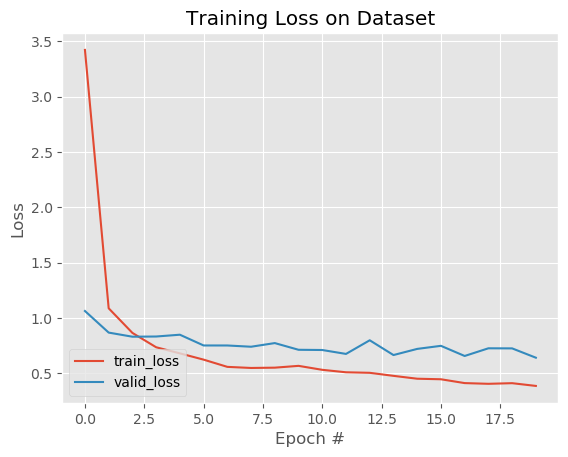

In [27]:
plt.style.use("ggplot")
plt.figure()
plt.plot(train_history["train_loss"], label="train_loss")
plt.plot(valid_history["valid_loss"], label="valid_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(PLOT_PATH)

In [28]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [29]:
def make_predictions(model, X, y):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
    
		orig = X.copy()
		gtMask = y.copy()
  
  
  		# make the channel axis to be the leading one, add a batch dimension, create a PyTorch tensor, and flash it to the current device
		image = np.transpose(X, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
  
		# make the prediction, and convert the result to a NumPy array
		predMask = model(image)[0].squeeze()
		predMask = predMask.cpu().numpy()
  
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

In [30]:
############# unet = torch.load(MODEL_PATH).to(DEVICE)

# iterate over the randomly selected test image paths
# for i in range(10):
	# make predictions and visualize the results
	# make_predictions(unet, X_train_npy[i], y_train_npy[i])

In [35]:
# load our model from disk and flash it to the current device
unet2 = UNet(
    input_shape=input_shape, n_input_channels=3, n_output_channels_b1=1, n_output_channels_b2=3, n_features= n_features, latent_dim=128).to(DEVICE)
optimizer2 = Adam(unet2.parameters(), lr=INIT_LR, weight_decay=1e-5)
model2, optimizer2, start_epoch = load_ckp(MODEL_PATH,unet2,optimizer2)

In [36]:
def DiceLoss_npy(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.multiply(y_true_f,y_pred_f)
    score = (2. * np.sum(intersection) + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    return (1-score).astype(np.float32)

def mse_loss_npy(imageA, imageB):
    imageA_f = imageA.flatten()
    imageB_f = imageB.flatten()
    return (np.sum((imageA_f - imageB_f) ** 2)/len(imageA_f)).astype(np.float32)

In [33]:
def get_avg_batch_loss(model, X, y, batch_size=BATCH_SIZE):
    
    d={}
    
    transforms_ = transforms.Compose([transforms.ToTensor()])

    # create the train and test datasets
    DS = SegmentationDataset(X=X, y=y, transforms=transforms_)
    print(f"[INFO] found {len(DS)} examples in the dataset.")

    # create the training and test data loaders
    loader = DataLoader(DS, batch_size=batch_size, pin_memory=PIN_MEMORY, num_workers=os.cpu_count(), shuffle=True, drop_last=True)
    steps = len(DS) // batch_size
    
    model.eval()
    
    with torch.no_grad():
        
        dice_loss = DiceLoss()
        mse_loss = nn.MSELoss()
        
        total_valid_dice_loss = 0
        total_valid_mse_b1_ip = 0
        total_valid_mse_b2_ip = 0
        total_valid_mse_b1_b2 = 0
        total_valid_kld_loss_ = 0
        total_valid_loss      = 0

        for (x_v, y_v) in loader:
      
			# send the input to the device
            (x_v, y_v) = (x_v.to(DEVICE), y_v.to(DEVICE))


			# make the predictions and calculate the validation loss
            valid_pred_b1_gry, valid_pred_b1_rgb, valid_pred_b2_rgb, valid_kld_loss = model(x_v)

            valid_dice_loss = dice_loss(valid_pred_b1_gry, y_v)
            valid_mse_b1_ip = mse_loss(valid_pred_b1_rgb.view(-1), x_v.view(-1))
            valid_mse_b2_ip = mse_loss(valid_pred_b2_rgb.view(-1), x_v.view(-1))
            valid_mse_b1_b2 = mse_loss(valid_pred_b1_rgb.view(-1), valid_pred_b2_rgb.view(-1))

            valid_loss = valid_dice_loss + valid_mse_b1_ip + valid_mse_b2_ip + valid_mse_b1_b2 + valid_kld_loss

            # add the loss to the total validation loss so far
            total_valid_dice_loss += valid_dice_loss
            total_valid_mse_b1_ip += valid_mse_b1_ip
            total_valid_mse_b2_ip += valid_mse_b2_ip
            total_valid_mse_b1_b2 += valid_mse_b1_b2
            total_valid_kld_loss_ += valid_kld_loss
            total_valid_loss += valid_loss

        d['dice']       = (total_valid_dice_loss.cpu().numpy()/steps)
        d['mse_b1_ip']  = (total_valid_mse_b1_ip.cpu().numpy()/steps)
        d['mse_b2_ip']  = (total_valid_mse_b2_ip.cpu().numpy()/steps)
        d['mse_b1_b2']  = (total_valid_mse_b1_b2.cpu().numpy()/steps)
        d['kld']        = (total_valid_kld_loss_.cpu().numpy()/steps)
        d['loss']       = (total_valid_loss.cpu().numpy()/steps)
    
    return d

In [34]:
def get_item_loss(model, X, y, d):
    
    model.eval()
    
    with torch.no_grad():
        
        image = np.transpose(X, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)
                
        pred_b1_gry, pred_b1_rgb, pred_b2_rgb, kld_loss  = model(image)
        
        
        image       = image.cpu().numpy()
        pred_b1_gry = pred_b1_gry.squeeze().cpu().numpy()
        pred_b1_rgb = pred_b1_rgb.cpu().numpy()
        pred_b2_rgb = pred_b2_rgb.cpu().numpy()
        
        dice      = DiceLoss_npy(y, pred_b1_gry)
        mse_b1_ip = mse_loss_npy(image, pred_b1_rgb)
        mse_b2_ip = mse_loss_npy(image, pred_b2_rgb)
        mse_b1_b2 = mse_loss_npy(pred_b1_rgb, pred_b2_rgb)
        kld       = kld_loss.cpu().numpy()
        
        d['dice']      += dice
        d['mse_b1_ip'] += mse_b1_ip
        d['mse_b2_ip'] += mse_b2_ip
        d['mse_b1_b2'] += mse_b1_b2
        d['kld']       += kld
        d['loss']      += (dice + mse_b1_ip + mse_b2_ip + mse_b1_b2 + kld)
    
    return d

def get_total_loss(model, X, y, avg=False):

    d={}
    d['dice'] = 0
    d['mse_b1_ip'] = 0
    d['mse_b2_ip'] = 0
    d['mse_b1_b2'] = 0
    d['kld'] = 0
    d['loss'] = 0
    
    for i in range(len(y)):
        get_item_loss(model2,X[i],y[i],d)

    if(avg):
        for k in d.keys():
            d[k]/=len(y)
        
    return d

In [24]:
get_total_loss(model2, X_valid_npy, y_valid_npy, True)

{'dice': 0.7852417607807091,
 'mse_b1_ip': 0.0032308683276334746,
 'mse_b2_ip': 0.000919841306565311,
 'mse_b1_b2': 0.0021654609192392127,
 'kld': 0.042585156243233,
 'loss': 0.8341430907103882}

In [25]:
get_avg_batch_loss(model2, X_valid_npy, y_valid_npy, 1)

[INFO] found 303 examples in the dataset.


{'dice': 0.7861897685740253,
 'mse_b1_ip': 0.0031516550004285554,
 'mse_b2_ip': 0.0009177680259490564,
 'mse_b1_b2': 0.0020916587842179602,
 'kld': 0.04258514316168555,
 'loss': 0.8349360097752939}

In [31]:
get_total_loss(model2, X_train_npy, y_train_npy, True)

{'dice': 0.7912083055363053,
 'mse_b1_ip': 0.0036996260728975683,
 'mse_b2_ip': 0.0009367308651285044,
 'mse_b1_b2': 0.0025975441089864386,
 'kld': 0.04061295180150631,
 'loss': 0.8390551581729615}

In [32]:
get_avg_batch_loss(model2, X_train_npy, y_train_npy, 1)

[INFO] found 897 examples in the dataset.


{'dice': 0.7909530248397436,
 'mse_b1_ip': 0.003657438018781817,
 'mse_b2_ip': 0.0009362698930295946,
 'mse_b1_b2': 0.002560508689752789,
 'kld': 0.04061293841205712,
 'loss': 0.8387198729924401}

In [40]:
# initialize a dictionary to store training history
train_history = {
    "train_loss": [],
	"train_dice_loss": [],
	"train_mse_b1_ip": [],
	"train_mse_b2_ip": [],
	"train_mse_b1_b2": [],
	"train_kld_loss_": [],
}

valid_history = {
	"valid_loss": [],
    "valid_dice_loss": [],
	"valid_mse_b1_ip": [],
	"valid_mse_b2_ip": [],
	"valid_mse_b1_b2": [],
	"valid_kld_loss_": [],
}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

for e in tqdm(range(NUM_EPOCHS)):

	print("-"*150)

	# set the model in training mode
	model2.train()
 
	# initialize the total training and validation loss
	total_train_loss = 0

	total_train_dice_loss = 0
	total_train_mse_b1_ip = 0
	total_train_mse_b2_ip = 0
	total_train_mse_b1_b2 = 0
	total_train_kld_loss_ = 0
 
	total_valid_loss = 0
 
	total_valid_dice_loss = 0
	total_valid_mse_b1_ip = 0
	total_valid_mse_b2_ip = 0
	total_valid_mse_b1_b2 = 0
	total_valid_kld_loss_ = 0

	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# print(i)
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
  
		# perform a forward pass and calculate the training loss
  
		pred_b1_gry, pred_b1_rgb, pred_b2_rgb, kld_loss = model2(x)

		dice_loss = dice(pred_b1_gry, y)
		mse_b1_ip = mse(pred_b1_rgb.view(-1), x.view(-1))
		mse_b2_ip = mse(pred_b2_rgb.view(-1), x.view(-1))
		mse_b1_b2 = mse(pred_b1_rgb.view(-1), pred_b2_rgb.view(-1))

		loss = dice_loss + mse_b1_ip + mse_b2_ip + mse_b1_b2 + kld_loss

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		optimizer2.zero_grad()
		loss.backward()
		optimizer2.step()
		
		# add the loss to the total training loss so far
  
		total_train_dice_loss += dice_loss
		total_train_mse_b1_ip += mse_b1_ip
		total_train_mse_b2_ip += mse_b2_ip
		total_train_mse_b1_b2 += mse_b1_b2
		total_train_kld_loss_ += kld_loss
  
		total_train_loss += loss
	
 
	# switch off autograd
	with torch.no_grad():
    
		# set the model in evaluation mode
		model2.eval()
  
		# loop over the validation set
		for (x_v, y_v) in validLoader:
      
			# send the input to the device
			(x_v, y_v) = (x_v.to(DEVICE), y_v.to(DEVICE))


			# make the predictions and calculate the validation loss
			valid_pred_b1_gry, valid_pred_b1_rgb, valid_pred_b2_rgb, valid_kld_loss = model2(x_v)

			valid_dice_loss = dice(valid_pred_b1_gry, y_v)
			valid_mse_b1_ip = mse(valid_pred_b1_rgb.view(-1), x_v.view(-1))
			valid_mse_b2_ip = mse(valid_pred_b2_rgb.view(-1), x_v.view(-1))
			valid_mse_b1_b2 = mse(valid_pred_b1_rgb.view(-1), valid_pred_b2_rgb.view(-1))

			valid_loss = valid_dice_loss + valid_mse_b1_ip + valid_mse_b2_ip + valid_mse_b1_b2 + valid_kld_loss
   
			# add the loss to the total validation loss so far
			total_valid_dice_loss += valid_dice_loss
			total_valid_mse_b1_ip += valid_mse_b1_ip
			total_valid_mse_b2_ip += valid_mse_b2_ip
			total_valid_mse_b1_b2 += valid_mse_b1_b2
			total_valid_kld_loss_ += valid_kld_loss
   
			total_valid_loss += valid_loss
   
	# calculate the average training loss
	avg_train_loss = total_train_loss / trainSteps
 
	avg_train_dice_loss = total_train_dice_loss / trainSteps
	avg_train_mse_b1_ip = total_train_mse_b1_ip / trainSteps
	avg_train_mse_b2_ip = total_train_mse_b2_ip / trainSteps
	avg_train_mse_b1_b2 = total_train_mse_b1_b2 / trainSteps
	avg_train_kld_loss_ = total_train_kld_loss_ / trainSteps
	
	# calculate the average validation loss
	avg_valid_loss = total_valid_loss / validSteps
 
	avg_valid_dice_loss = total_valid_dice_loss / validSteps
	avg_valid_mse_b1_ip = total_valid_mse_b1_ip / validSteps
	avg_valid_mse_b2_ip = total_valid_mse_b2_ip / validSteps
	avg_valid_mse_b1_b2 = total_valid_mse_b1_b2 / validSteps
	avg_valid_kld_loss_ = total_valid_kld_loss_ / validSteps
 
	# update our training history

	train_history["train_loss"].append(avg_train_loss.cpu().detach().numpy())
 
	train_history["train_dice_loss"].append(avg_train_dice_loss.cpu().detach().numpy())
	train_history["train_mse_b1_ip"].append(avg_train_mse_b1_ip.cpu().detach().numpy())
	train_history["train_mse_b2_ip"].append(avg_train_mse_b2_ip.cpu().detach().numpy())
	train_history["train_mse_b1_b2"].append(avg_train_mse_b1_b2.cpu().detach().numpy())
	train_history["train_kld_loss_"].append(avg_train_kld_loss_.cpu().detach().numpy())
 
	valid_history["valid_loss"].append(avg_valid_loss.cpu().detach().numpy())
 
	valid_history["valid_dice_loss"].append(avg_valid_dice_loss.cpu().detach().numpy())
	valid_history["valid_mse_b1_ip"].append(avg_valid_mse_b1_ip.cpu().detach().numpy())
	valid_history["valid_mse_b2_ip"].append(avg_valid_mse_b2_ip.cpu().detach().numpy())
	valid_history["valid_mse_b1_b2"].append(avg_valid_mse_b1_b2.cpu().detach().numpy())
	valid_history["valid_kld_loss_"].append(avg_valid_kld_loss_.cpu().detach().numpy())
 
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))

	print("Train Loss : {:.4f}, Train Dice Loss : {:.4f}, Train MSE B1 ip : {:.4f}, Train MSE B2 ip : {:.4f}, Train MSE B1 B2 : {:.4f}, Train KLD Loss  : {:.4f}"
    .format(avg_train_loss, avg_train_dice_loss, avg_train_mse_b1_ip, avg_train_mse_b2_ip, avg_train_mse_b1_b2, avg_train_kld_loss_))
 
	print("Valid Loss : {:.4f}, Valid Dice Loss : {:.4f}, Valid MSE B1 ip : {:.4f}, Valid MSE B2 ip : {:.4f}, Valid MSE B1 B2 : {:.4f}, Valid KLD Loss  : {:.4f}"
    .format(avg_valid_loss, avg_valid_dice_loss, avg_valid_mse_b1_ip, avg_valid_mse_b2_ip, avg_valid_mse_b1_b2, avg_valid_kld_loss_))

	save_best_model(avg_valid_dice_loss, e, model2, optimizer2)
	
# display the total time needed to perform the training
endTime = time.time()
print("-"*150)
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------


  5%|▌         | 1/20 [01:07<21:25, 67.66s/it]

[INFO] EPOCH: 1/20
Train Loss : 0.1686, Train Dice Loss : 0.1634, Train MSE B1 ip : 0.0008, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0038
Valid Loss : 0.5663, Valid Dice Loss : 0.5613, Valid MSE B1 ip : 0.0015, Valid MSE B2 ip : 0.0007, Valid MSE B1 B2 : 0.0004, Valid KLD Loss  : 0.0024
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 2/20
Train Loss : 0.1729, Train Dice Loss : 0.1667, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0051
Valid Loss : 0.5325, Valid Dice Loss : 0.5244, Valid MSE B1 ip : 0.0008, Valid MSE B2 ip : 0.0002, Valid MSE B1 B2 : 0.0005, Valid KLD Loss  : 0.0067
Best validation dice loss: 0.5244 , Saving best model for epoch: 2.


 10%|█         | 2/20 [02:21<21:19, 71.07s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 3/20
Train Loss : 0.1877, Train Dice Loss : 0.1797, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0067
Valid Loss : 0.5344, Valid Dice Loss : 0.5198, Valid MSE B1 ip : 0.0006, Valid MSE B2 ip : 0.0004, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0135
Best validation dice loss: 0.5198 , Saving best model for epoch: 3.


 15%|█▌        | 3/20 [03:34<20:24, 72.03s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 20%|██        | 4/20 [04:42<18:49, 70.59s/it]

[INFO] EPOCH: 4/20
Train Loss : 0.1773, Train Dice Loss : 0.1612, Train MSE B1 ip : 0.0005, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0151
Valid Loss : 0.5752, Valid Dice Loss : 0.5722, Valid MSE B1 ip : 0.0005, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0020
------------------------------------------------------------------------------------------------------------------------------------------------------


 25%|██▌       | 5/20 [05:51<17:27, 69.83s/it]

[INFO] EPOCH: 5/20
Train Loss : 0.1854, Train Dice Loss : 0.1619, Train MSE B1 ip : 0.0005, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0225
Valid Loss : 0.5554, Valid Dice Loss : 0.5470, Valid MSE B1 ip : 0.0005, Valid MSE B2 ip : 0.0002, Valid MSE B1 B2 : 0.0003, Valid KLD Loss  : 0.0074
------------------------------------------------------------------------------------------------------------------------------------------------------


 30%|███       | 6/20 [06:59<16:11, 69.40s/it]

[INFO] EPOCH: 6/20
Train Loss : 0.1678, Train Dice Loss : 0.1619, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0045
Valid Loss : 0.5276, Valid Dice Loss : 0.5220, Valid MSE B1 ip : 0.0009, Valid MSE B2 ip : 0.0002, Valid MSE B1 B2 : 0.0008, Valid KLD Loss  : 0.0037
------------------------------------------------------------------------------------------------------------------------------------------------------


 35%|███▌      | 7/20 [08:08<14:58, 69.10s/it]

[INFO] EPOCH: 7/20
Train Loss : 0.1729, Train Dice Loss : 0.1655, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0063
Valid Loss : 0.5589, Valid Dice Loss : 0.5518, Valid MSE B1 ip : 0.0023, Valid MSE B2 ip : 0.0002, Valid MSE B1 B2 : 0.0021, Valid KLD Loss  : 0.0026
------------------------------------------------------------------------------------------------------------------------------------------------------


 40%|████      | 8/20 [09:16<13:46, 68.89s/it]

[INFO] EPOCH: 8/20
Train Loss : 0.1818, Train Dice Loss : 0.1736, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0070
Valid Loss : 0.7404, Valid Dice Loss : 0.7322, Valid MSE B1 ip : 0.0013, Valid MSE B2 ip : 0.0015, Valid MSE B1 B2 : 0.0004, Valid KLD Loss  : 0.0051
------------------------------------------------------------------------------------------------------------------------------------------------------


 45%|████▌     | 9/20 [10:25<12:36, 68.74s/it]

[INFO] EPOCH: 9/20
Train Loss : 0.1730, Train Dice Loss : 0.1677, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0003, Train KLD Loss  : 0.0040
Valid Loss : 0.5926, Valid Dice Loss : 0.5832, Valid MSE B1 ip : 0.0034, Valid MSE B2 ip : 0.0014, Valid MSE B1 B2 : 0.0028, Valid KLD Loss  : 0.0018
------------------------------------------------------------------------------------------------------------------------------------------------------


 50%|█████     | 10/20 [11:33<11:26, 68.67s/it]

[INFO] EPOCH: 10/20
Train Loss : 0.1753, Train Dice Loss : 0.1711, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0031
Valid Loss : 0.5397, Valid Dice Loss : 0.5361, Valid MSE B1 ip : 0.0005, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0026
------------------------------------------------------------------------------------------------------------------------------------------------------


 55%|█████▌    | 11/20 [12:41<10:17, 68.58s/it]

[INFO] EPOCH: 11/20
Train Loss : 0.1578, Train Dice Loss : 0.1515, Train MSE B1 ip : 0.0005, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0053
Valid Loss : 0.5303, Valid Dice Loss : 0.5249, Valid MSE B1 ip : 0.0007, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0004, Valid KLD Loss  : 0.0040
------------------------------------------------------------------------------------------------------------------------------------------------------


 60%|██████    | 12/20 [13:50<09:08, 68.53s/it]

[INFO] EPOCH: 12/20
Train Loss : 0.1559, Train Dice Loss : 0.1485, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0063
Valid Loss : 0.5334, Valid Dice Loss : 0.5200, Valid MSE B1 ip : 0.0004, Valid MSE B2 ip : 0.0001, Valid MSE B1 B2 : 0.0003, Valid KLD Loss  : 0.0127
------------------------------------------------------------------------------------------------------------------------------------------------------


 65%|██████▌   | 13/20 [14:58<07:59, 68.52s/it]

[INFO] EPOCH: 13/20
Train Loss : 0.1610, Train Dice Loss : 0.1504, Train MSE B1 ip : 0.0005, Train MSE B2 ip : 0.0002, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0097
Valid Loss : 0.5345, Valid Dice Loss : 0.5304, Valid MSE B1 ip : 0.0008, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0006, Valid KLD Loss  : 0.0025
------------------------------------------------------------------------------------------------------------------------------------------------------


 70%|███████   | 14/20 [16:07<06:50, 68.48s/it]

[INFO] EPOCH: 14/20
Train Loss : 0.1706, Train Dice Loss : 0.1630, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0063
Valid Loss : 0.5446, Valid Dice Loss : 0.5390, Valid MSE B1 ip : 0.0007, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0003, Valid KLD Loss  : 0.0043
------------------------------------------------------------------------------------------------------------------------------------------------------


 75%|███████▌  | 15/20 [17:15<05:42, 68.48s/it]

[INFO] EPOCH: 15/20
Train Loss : 0.1612, Train Dice Loss : 0.1576, Train MSE B1 ip : 0.0007, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0024
Valid Loss : 0.5912, Valid Dice Loss : 0.5894, Valid MSE B1 ip : 0.0005, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0008
------------------------------------------------------------------------------------------------------------------------------------------------------


 80%|████████  | 16/20 [18:24<04:33, 68.48s/it]

[INFO] EPOCH: 16/20
Train Loss : 0.1699, Train Dice Loss : 0.1668, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0020
Valid Loss : 0.5714, Valid Dice Loss : 0.5695, Valid MSE B1 ip : 0.0003, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0011
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] EPOCH: 17/20
Train Loss : 0.1377, Train Dice Loss : 0.1343, Train MSE B1 ip : 0.0005, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0025
Valid Loss : 0.5067, Valid Dice Loss : 0.5038, Valid MSE B1 ip : 0.0002, Valid MSE B2 ip : 0.0001, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0024
Best validation dice loss: 0.5038 , Saving best model for epoch: 17.


 85%|████████▌ | 17/20 [19:37<03:29, 69.95s/it]

------------------------------------------------------------------------------------------------------------------------------------------------------


 90%|█████████ | 18/20 [20:45<02:18, 69.44s/it]

[INFO] EPOCH: 18/20
Train Loss : 0.1260, Train Dice Loss : 0.1225, Train MSE B1 ip : 0.0004, Train MSE B2 ip : 0.0002, Train MSE B1 B2 : 0.0001, Train KLD Loss  : 0.0028
Valid Loss : 0.5160, Valid Dice Loss : 0.5121, Valid MSE B1 ip : 0.0002, Valid MSE B2 ip : 0.0001, Valid MSE B1 B2 : 0.0001, Valid KLD Loss  : 0.0034
------------------------------------------------------------------------------------------------------------------------------------------------------


 95%|█████████▌| 19/20 [21:54<01:09, 69.16s/it]

[INFO] EPOCH: 19/20
Train Loss : 0.1449, Train Dice Loss : 0.1410, Train MSE B1 ip : 0.0006, Train MSE B2 ip : 0.0003, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0028
Valid Loss : 0.5259, Valid Dice Loss : 0.5213, Valid MSE B1 ip : 0.0003, Valid MSE B2 ip : 0.0003, Valid MSE B1 B2 : 0.0002, Valid KLD Loss  : 0.0039
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 20/20 [23:02<00:00, 69.13s/it]

[INFO] EPOCH: 20/20
Train Loss : 0.1343, Train Dice Loss : 0.1305, Train MSE B1 ip : 0.0008, Train MSE B2 ip : 0.0004, Train MSE B1 B2 : 0.0002, Train KLD Loss  : 0.0024
Valid Loss : 0.5561, Valid Dice Loss : 0.5526, Valid MSE B1 ip : 0.0005, Valid MSE B2 ip : 0.0002, Valid MSE B1 B2 : 0.0003, Valid KLD Loss  : 0.0025
------------------------------------------------------------------------------------------------------------------------------------------------------
[INFO] total time taken to train the model: 1382.69s
